In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as utils
from torchvision.utils import save_image
from frechet_distance_cal import calculate_fretchet
import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, text_input_dim, noise_dim):
        super(Generator, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(text_input_dim, 256),
            nn.ReLU(),
        )
        self.model = nn.Sequential(
            nn.Linear(noise_dim + 256, 512*4*4),
            nn.BatchNorm1d(512*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, text_input, noise):
        text_embedding = self.text_embedding(text_input)
        x = torch.cat([noise, text_embedding], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, text_input_dim):
        super(Discriminator, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(text_input_dim, 256),
            nn.ReLU(),
        )
        self.image_model = nn.Sequential(
            nn.Conv2d(3, 64, 5, 2, 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 5, 2, 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 5, 2, 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 5, 2, 2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        self.concat = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4 + 256, 1),
            nn.Sigmoid(),
        )

    def forward(self, image_input, text_input):
        text_embedding = self.text_embedding(text_input)
        text_embedding = text_embedding.view(-1, 256)
        image_features = self.image_model(image_input)
        image_features = image_features.view(image_input.size(0), -1)
        combined = torch.cat([image_features, text_embedding], dim=1)
        return self.concat(combined)
    

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def get_random_text_input(batch_size, text_input_dim, device):
    return torch.randn(batch_size, text_input_dim, device=device)

def plot_and_save_graph(gen_loss, dis_loss, fretchet_distances, out_path, epochs):
    import matplotlib.pyplot as plt
    import os
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(gen_loss, label="Generator")
    plt.plot(dis_loss, label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Generator and Discriminator Loss During Training")

    plt.subplot(2, 1, 2)
    plt.plot(range(epochs), fretchet_distances, label="FID")
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.legend()
    plt.title("FID vs Epochs")

    plt.subplots_adjust(hspace=0.5) 

In [3]:
netG = Generator(119, 100).to(device)
netD = Discriminator(119).to(device)
netG.apply(weights_init)
netD.apply(weights_init)

batch_size = 128
lr = 0.0002
beta1 = 0.5
epochs = 40
nz = 100
text_input_dim = 119
fixed_noise = torch.randn(32, nz, device=device)
text_input_batch = get_random_text_input(32, text_input_dim, device)
iters = 0
G_losses = list()
D_losses = list()
img_list = list()
fretchet_distances = list()
out_path = 'DCGaN_Out_40'
os.makedirs(out_path, exist_ok=True)

optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


In [4]:
netG.train(),netD.train()

(Generator(
   (text_embedding): Sequential(
     (0): Linear(in_features=119, out_features=256, bias=True)
     (1): ReLU()
   )
   (model): Sequential(
     (0): Linear(in_features=356, out_features=8192, bias=True)
     (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Unflatten(dim=1, unflattened_size=(512, 4, 4))
     (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): ReLU()
     (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (9): ReLU()
     (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (12): ReLU()
     (13): ConvTranspose2d(64,

/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.10-dtqfczcbv33ugxmsznhll4vjexdcxjfn/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.10-dtqfczcbv33ugxmsznhll4vjexdcxjfn/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch [0/40] Batch 390/391 Loss Discriminator: 0.329, Loss Generator: 4.265 FID: 458.477

Epoch [5/40] Batch 390/391 Loss Discriminator: 0.602, Loss Generator: 2.207 FID: 281.974

Epoch [10/40] Batch 390/391 Loss Discriminator: 0.741, Loss Generator: 2.109 FID: 262.211

Epoch [15/40] Batch 390/391 Loss Discriminator: 0.039, Loss Generator: 4.207 FID: 270.465

Epoch [20/40] Batch 390/391 Loss Discriminator: 0.894, Loss Generator: 7.664 FID: 248.988

Epoch [25/40] Batch 390/391 Loss Discriminator: 0.026, Loss Generator: 5.149 FID: 273.779

Epoch [30/40] Batch 390/391 Loss Discriminator: 0.134, Loss Generator: 3.215 FID: 259.774

Epoch [35/40] Batch 390/391 Loss Discriminator: 0.457, Loss Generator: 4.389 FID: 237.167
Training has finished.


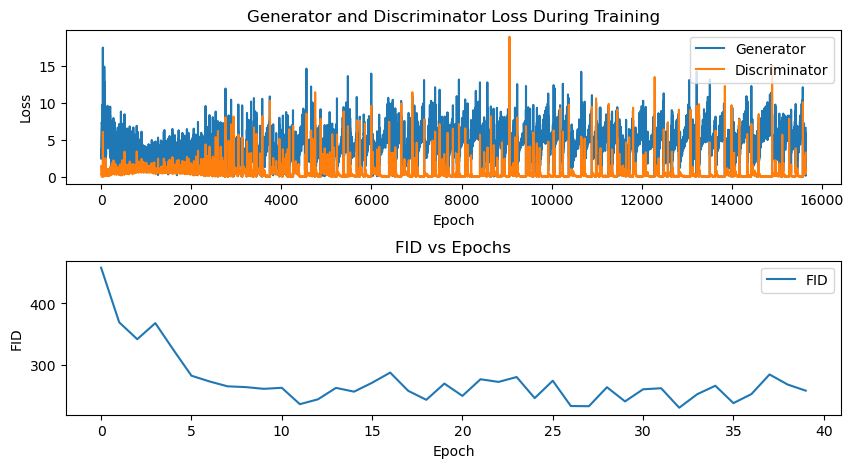

In [5]:
for epoch in range(epochs):
    for i, (data, _) in enumerate(dataloader):
        real_data = data.to(device)
        b_size = real_data.size(0)
        real_label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        fake_label = torch.full((b_size,), 0, dtype=torch.float, device=device)

        # Train Discriminator with real data
        netD.zero_grad()
        output = netD(real_data, torch.randn(b_size, 119, device=device)).view(-1)
        errD_real = criterion(output, real_label)
        errD_real.backward()

        # Train Discriminator with fake data
        noise = torch.randn(b_size, 100, device=device)
        fake_data = netG(torch.randn(b_size, 119, device=device), noise)
        output = netD(fake_data.detach(), torch.randn(b_size, 119, device=device)).view(-1)
        errD_fake = criterion(output, fake_label)
        errD_fake.backward()
        optimizerD.step()
        errD = errD_fake+errD_real
        # Train Generator
        netG.zero_grad()
        output = netD(fake_data, torch.randn(b_size, 119, device=device)).view(-1)
        errG = criterion(output, real_label)
        errG.backward()
        optimizerG.step()

        G_losses.append(errG.detach().cpu())
        D_losses.append(errD.detach().cpu())
        # Save G's output on fixed_noise every 500 iterations
        if (iters % 300 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_images = netG(text_input_batch, fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake_images, padding=2, normalize=True))

        iters += 1

    with torch.no_grad():
        fretchet_dist = calculate_fretchet(real_data.cpu(), fake_data.cpu())
    fretchet_distances.append(fretchet_dist)

    if epoch % 5 == 0:
        print(f'\nEpoch [{epoch}/{epochs}] Batch {i}/{len(dataloader)} '
              f'Loss Discriminator: {errD.item():.3f}, Loss Generator: {errG.item():.3f} FID: {fretchet_dist:.3f}')
        with torch.no_grad():
            images = netG(text_input_batch, fixed_noise).detach()
    image_fake_path = out_path+'/fake_samples_epoch_%03d.png' % epoch
    image_real_path = out_path+'/real_samples_epoch_%03d.png' % epoch
    utils.save_image(images.detach(),image_fake_path, normalize = True)
    utils.save_image(real_data.detach(),image_real_path, normalize = True)

with open(os.path.join(out_path, 'gen_error.txt'), 'w') as f:
    for line in G_losses:
        f.write(f"{line}\n")

with open(os.path.join(out_path, 'dis_error.txt'), 'w') as f:
    for line in D_losses:
        f.write(f"{line}\n")

with open(os.path.join(out_path, 'fretchet_distances.txt'), 'w') as f:
    for line in fretchet_distances:
        f.write(f"{line}\n")

plot_and_save_graph(G_losses, D_losses, fretchet_distances, out_path, epochs)
print('Training has finished.')

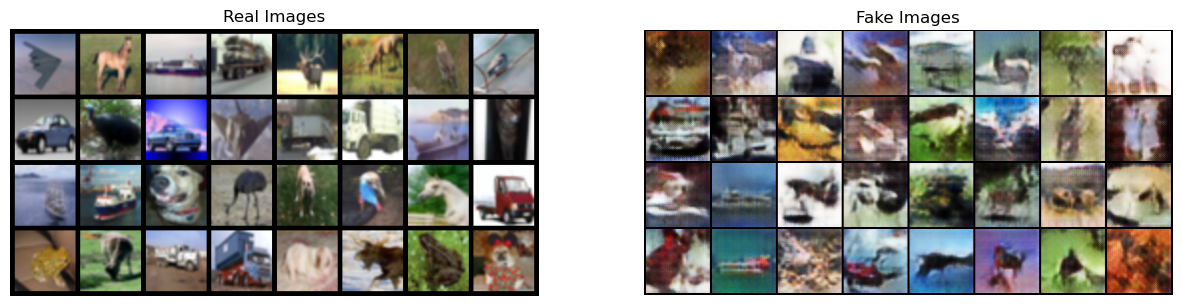

In [6]:
import numpy as np
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('DCGaN_Out_40/DCGAN30_BEST_FAKE_32.png',
            format='png',
            bbox_inches='tight')
plt.show()